In [12]:
from functools import partial
from pathlib import Path

import h5py
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from qso.utils import init_weights, load_ds, predict

In [13]:
rc("font", family="serif")
rc("text", usetex=True)

In [2]:
ds_file = Path("data") / "dataset.hdf5"
bs = 64
bs_eval = 2048

src_dl = DataLoader(load_ds(ds_file, "sdss"), batch_size=bs, shuffle=True)
trg_dl = DataLoader(load_ds(ds_file, "lamost"), batch_size=bs, shuffle=True)
src_dl_va = DataLoader(load_ds(ds_file, "sdss", va=True), batch_size=bs_eval)
trg_dl_va = DataLoader(load_ds(ds_file, "lamost", va=True), batch_size=bs_eval)

In [3]:
class LeNet_5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.pool1 = nn.MaxPool1d(16, 16)
        self.conv2 = nn.Conv1d(32, 48, 5, padding=2)
        self.pool2 = nn.MaxPool1d(16, 16)
        self.fc1 = nn.Linear(48 * 14, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
    
    def forward_conv(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        return x

    def forward_fc1(self, x):
        x = self.forward_conv(x)
        x = F.relu(self.fc1(x))
        return x

    def forward_fc2(self, x):
        x = self.forward_fc1(x)
        x = F.relu(self.fc2(x))
        return x

    def forward(self, x):
        x = self.forward_fc2(x)
        x = self.fc3(x)
        return x

def mmd(src_f, trg_f):
    mmd = src_f.sum(axis=0) / src_f.size(0) - trg_f.sum(axis=0) / trg_f.size(0)
    return mmd @ mmd.T

def eval_layer(layer, src_dl, trg_dl, bottleneck, dev):
    assert src_dl.batch_size == trg_dl.batch_size
    bs = src_dl.batch_size
    src_fs = torch.zeros(src_dl.dataset.tensors[0].size(0), bottleneck)
    trg_fs = torch.zeros(trg_dl.dataset.tensors[0].size(0), bottleneck)
    for i, ((src_xb, _), (trg_xb, _)) in enumerate(zip(src_dl, trg_dl)):
        start = i * bs
        end = start + bs
        src_fs[start:end] = layer(src_xb.to(dev)).squeeze()
        trg_fs[start:end] = layer(trg_xb.to(dev)).squeeze()
    return torch.sqrt(mmd(src_fs, trg_fs)).item()

dev = torch.device("cuda")
lenet = LeNet_5().to(dev)
lenet_pt = Path("models") / "lenet-5.pt"
lenet.load_state_dict(torch.load(lenet_pt))
with torch.no_grad():
    fc1_mmd = eval_layer(lenet.forward_fc1, src_dl_va, trg_dl_va, 100, dev)
    fc2_mmd = eval_layer(lenet.forward_fc2, src_dl_va, trg_dl_va, 100, dev)
fc1_mmd, fc2_mmd

(41.90813446044922, 39.49795150756836)

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.pool1 = nn.MaxPool1d(16, 16)
        self.conv2 = nn.Conv1d(32, 48, 5, padding=2)
        self.pool2 = nn.MaxPool1d(16, 16)
        self.fc1 = nn.Linear(48 * 14, 100)
        self.fc2 = nn.Linear(100, 100)
        self.bottleneck = nn.Linear(100, bottleneck)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.bottleneck(x))
        return x

class Predictor(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        self.fc3 = nn.Linear(bottleneck, 1)

    def forward(self, x):
        x = self.fc3(x)
        return x

class DDC(nn.Module):
    def __init__(self, bottleneck):
        super().__init__()
        self.feature_extractor = FeatureExtractor(bottleneck)
        self.predictor = Predictor(bottleneck)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.predictor(x)
        return x

In [5]:
dev = torch.device("cuda")
criterion = nn.BCEWithLogitsLoss()

bottlenecks, mmds = [2, 4, 8, 16, 32, 64], []
for bottleneck in bottlenecks:
    model = DDC(bottleneck).to(dev)
    model.apply(init_weights)
    opt = optim.Adam(model.parameters())
    writer = SummaryWriter(comment="_ddc")
    
    epochs = 20
    for epoch in range(1, epochs + 1):
        for xb, yb in src_dl:
            xb, yb = xb.to(dev), yb.to(dev)
            loss = criterion(model(xb), yb.unsqueeze(-1))
            loss.backward()
            opt.step()
            opt.zero_grad()

        with torch.no_grad():
            mmd_value = eval_layer(model.feature_extractor, src_dl_va, trg_dl_va, bottleneck, dev)
            src_trues_va, src_preds_va = predict(model, src_dl_va, dev)

        writer.add_scalar("loss/validation", criterion(src_preds_va, src_trues_va), epoch)
        writer.add_scalar("loss/mmd", mmd_value, epoch)

    mmds.append(mmd_value)
    torch.save(model.state_dict(), "ddc_{:02d}.pt".format(bottleneck))

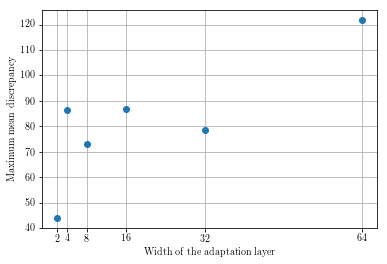

In [14]:
ax = plt.axes(
    xlabel="Width of the adaptation layer",
    ylabel="Maximum mean discrepancy",
    xticks=bottlenecks
)
ax.plot(bottlenecks, mmds, 'o')
ax.grid(True)
plt.savefig(str(Path("figs") / "adaptation_layer_width.pdf"))

In [9]:
def loss_clf_mmd(model, src_dl, trg_dl, bottleneck, dev):
    assert src_dl.batch_size == trg_dl.batch_size
    bs = src_dl.batch_size
    y_true = torch.zeros(src_dl.dataset.tensors[0].size(0))
    y_pred = torch.zeros_like(y_true)
    src_fs = torch.zeros(src_dl.dataset.tensors[0].size(0), bottleneck)
    trg_fs = torch.zeros_like(src_fs)
    for i, ((src_xb, src_yb), (trg_xb, _)) in enumerate(zip(src_dl, trg_dl)):
        src_xb, src_yb, trg_xb = src_xb.to(dev), src_yb.to(dev), trg_xb.to(dev)
        start = i * bs
        end = start + bs
        src_fb = model.feature_extractor(src_xb)
        src_fs[start:end] = src_fb
        trg_fs[start:end] = model.feature_extractor(trg_xb)
        y_true[start:end] = src_yb
        y_pred[start:end] = model.predictor(src_fb).squeeze()
    loss_clf = criterion(y_pred, y_true)
    loss_mmd = mmd(src_fs, trg_fs)
    return loss_clf, loss_mmd

In [ ]:
dev = torch.device("cuda")
criterion = nn.BCEWithLogitsLoss()
bottleneck = 8
model = DDC(bottleneck).to(dev)
model.apply(init_weights)
opt = optim.Adam(model.parameters())

writer = SummaryWriter(comment="_ddc")

lam = 0.25
epochs = 20
for epoch in range(1, epochs + 1):
    for (src_xb, src_yb), (trg_xb, _) in zip(src_dl, trg_dl):
        src_xb, src_yb, trg_xb = src_xb.to(dev), src_yb.to(dev), trg_xb.to(dev)
        src_fb, trg_fb = model.feature_extractor(src_xb), model.feature_extractor(trg_xb)
        loss_clf = criterion(model.predictor(src_fb), src_yb.unsqueeze(-1))
        loss_mmd = mmd(src_fb, trg_fb)
        loss = loss_clf + lam * loss_mmd
        loss.backward()
        opt.step()
        opt.zero_grad()

    with torch.no_grad():
        loss_clf, loss_mmd = loss_clf_mmd(model, src_dl, trg_dl, bottleneck, dev)
        src_trues_va, src_preds_va = predict(model, src_dl_va, dev)
        trg_trues_va, trg_preds_va = predict(model, trg_dl_va, dev)

    writer.add_scalars("loss", {"training": loss_clf,
                                "mmd": loss_mmd,
                                "validation": criterion(src_preds_va, src_trues_va)}, epoch)
    writer.add_scalars("f1", {"source": f1_score(src_trues_va.bool(), src_preds_va > 0),
                              "target": f1_score(trg_trues_va.bool(), trg_preds_va > 0)}, epoch)

    torch.save(model.state_dict(), "ddc_{:02d}-epoch.pt".format(epoch))